<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def avg(Di,Dj):
    """
    Computes the harmonic average between two values Di and Dj
    Returns 0 if either of them is zero
    """
    if (Di*Dj) == 0:
        return 0
    else:
        return 2/(1/Di+1/Dj)

In [3]:
def Build_1D_Inhomo_Matrix_Source(bc_left, bc_right, n, D, Width, poro,Q):
    """
    Constructs a coefficient matrix and an array with varying diffusion coefficient and a source term
    Parameters:
    --------------
    bc_left: (float)  left boundary condition
    bc_right: (float) right boundary conditions
    n (int): amounts of cells
    D (float array): values of the diffusion coefficient
    Width (float): Total phyiscal width of the domain
    poro (float): porosity value
    Q (float array): volumetric source term
    Returns the matrix A, and the array b to solve the
    discretized 1D diffusion problem Ax = b
    
    ----------
    """
    Matrix = np.zeros((n,n))
    RHS = np.zeros(n)
    dx = Width/(n-1)
    dy = dz = dx
    coef = poro/dx/dx
    for i in range(n):
        if i == 0:
            if(bc_left == -1):
                Matrix[i][i] = 1
                Matrix[i][i+1] = -1
            else:
                RHS[i] = bc_left
                Matrix[i][i] = 1
        elif i == n-1:
            RHS[i] = bc_right
            Matrix[i][i] = 1
        else:
            RHS[i] = Q[i]
            East = coef*avg(D[i],D[i+1])
            West = coef*avg(D[i],D[i-1])
            Matrix[i][i] = East+West
            Matrix[i][i+1] = - East
            Matrix[i][i-1] = - West      
    return Matrix, RHS

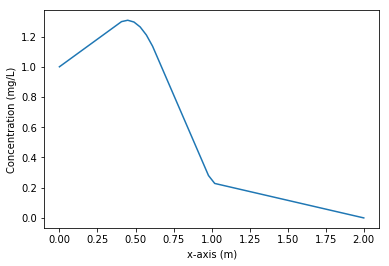

In [4]:
c_left = 1
c_right = 0
n = 50
Diff = 2e-9
D = Diff*np.ones(n)
Q = np.zeros(n)
Q[int(n/5):int(n/3)] = 1e-9 #mg/L/s

for i in range(int(n/2)):
    D[i] = Diff/10
Width = 2 
poro = 0.4
x = np.linspace(0,Width,n)
A, b = Build_1D_Inhomo_Matrix_Source(c_left, c_right, n, D, Width, poro,Q)

c_final = np.linalg.solve(A,b)
plt.plot(x, c_final, label="Concentration")
plt.xlabel("x-axis (m)")
plt.ylabel("Concentration (mg/L)");

Transient behavior


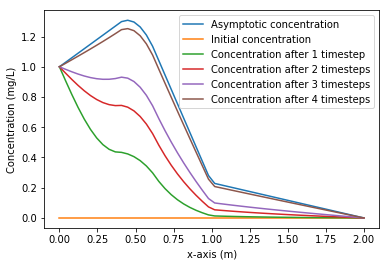

In [5]:
nTstp = 200
dt = 1e7

Diff = 2e-9
D = Diff*np.ones(n)
Q = np.zeros(n)
Q[int(n/5):int(n/3)] = 1e-9 #mg/L/s
for i in range(int(n/2)):
    D[i] = Diff/10
Width = 2 

poro = 0.4
x = np.linspace(0,Width,n)
A, b = Build_1D_Inhomo_Matrix_Source(c_left, c_right, n, D, Width, poro, Q)

c = np.zeros((nTstp,n))

for t in range(nTstp-1):
    Abis = np.zeros((n,n))
    Bbis = np.zeros(n)
    for i in range(n):
        Abis[i][i] = poro/dt
        Bbis[i] = c[t][i]*poro/dt
    Aa = A + Abis
    bb = b + Bbis
    cnew = np.linalg.solve(Aa,bb)
    c[t+1][:]=cnew

plt.plot(x,c_final, label="Asymptotic concentration")
plt.plot(x, c[0][:], label="Initial concentration")
plt.plot(x, c[24][:], label="Concentration after 1 timestep")
plt.plot(x, c[49][:], label="Concentration after 2 timesteps")
plt.plot(x, c[74][:], label="Concentration after 3 timesteps")
plt.plot(x, c[nTstp-1][:], label="Concentration after 4 timesteps")
plt.xlabel("x-axis (m)")
plt.ylabel("Concentration (mg/L)");
plt.legend();

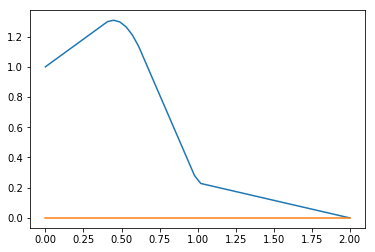

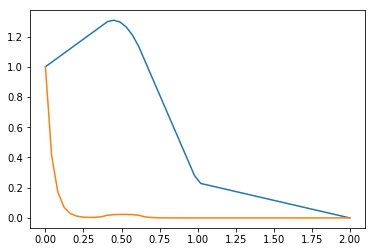

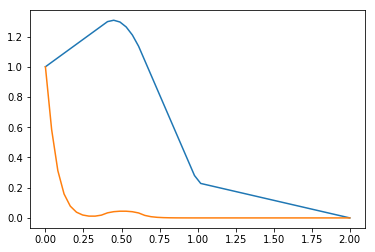

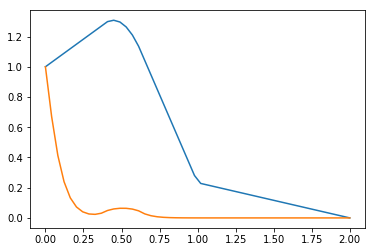

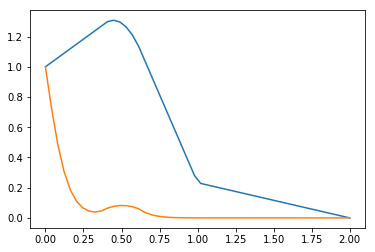

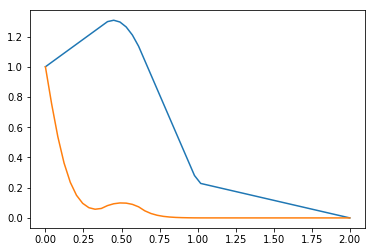

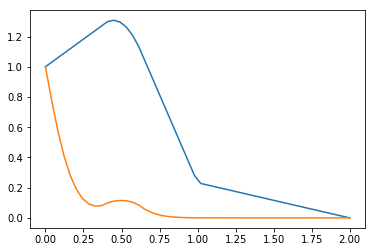

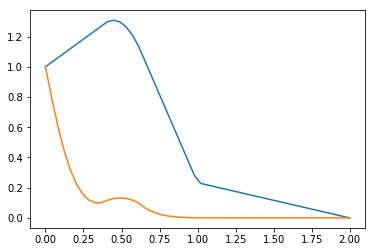

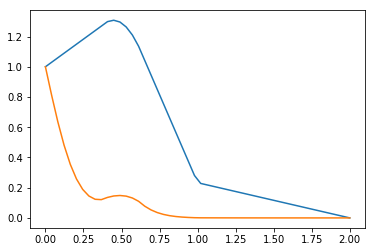

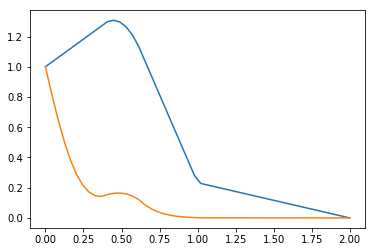

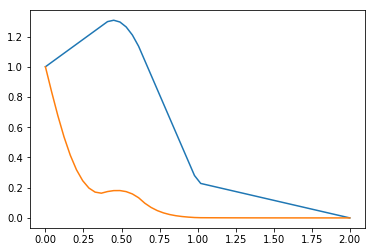

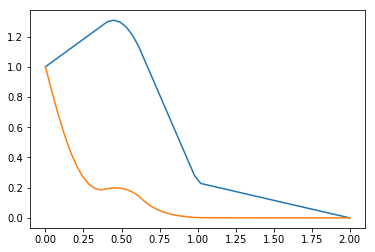

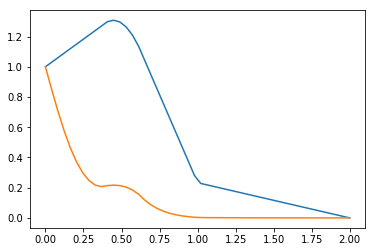

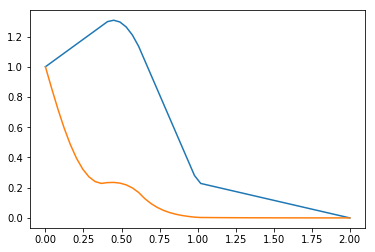

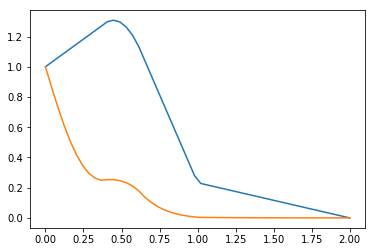

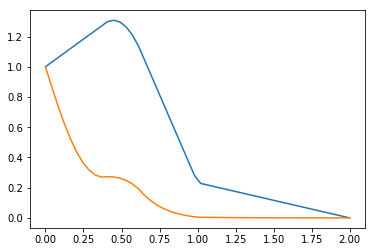

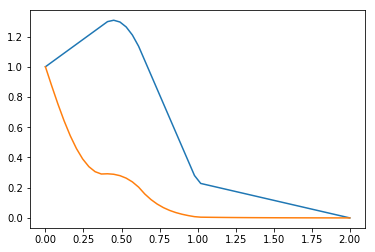

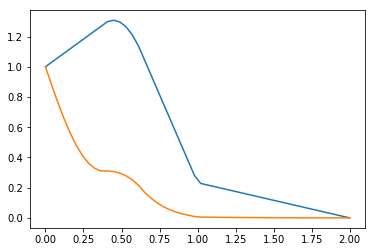

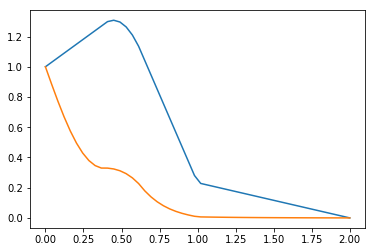

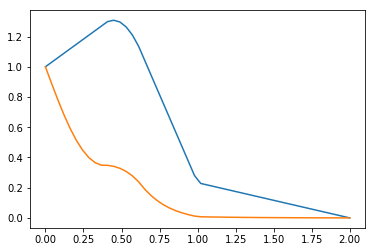

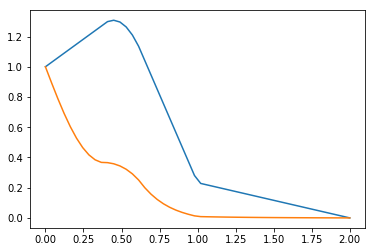

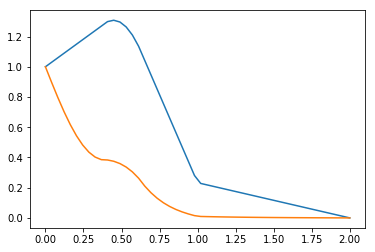

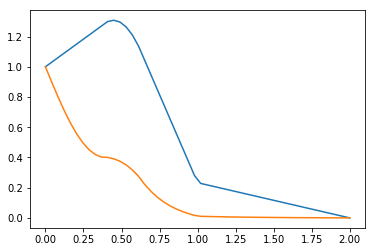

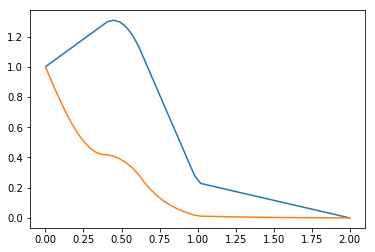

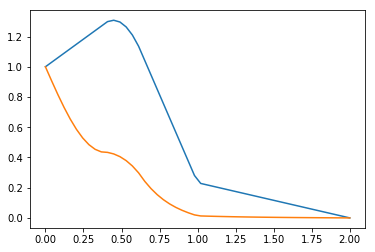

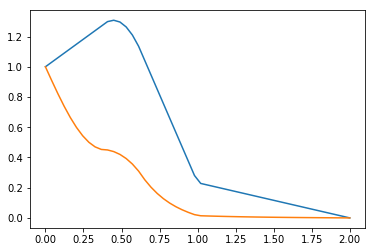

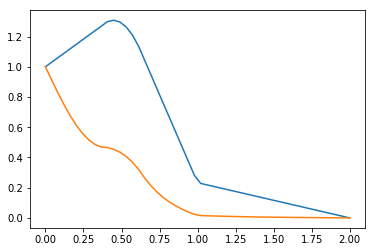

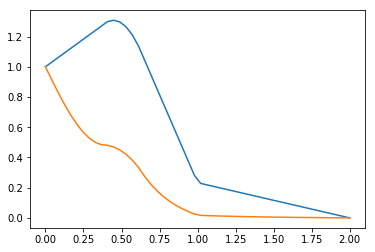

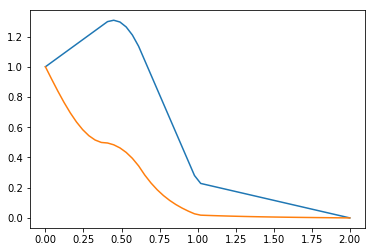

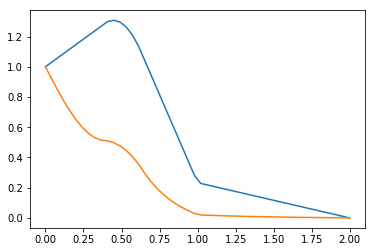

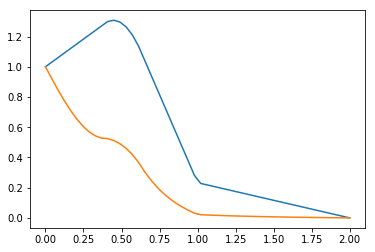

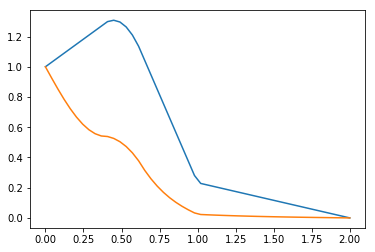

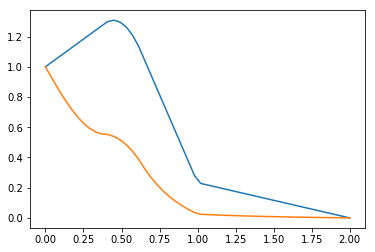

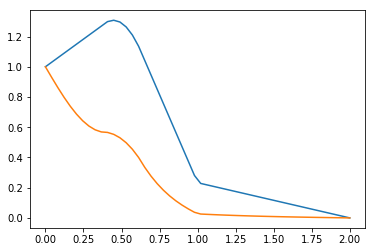

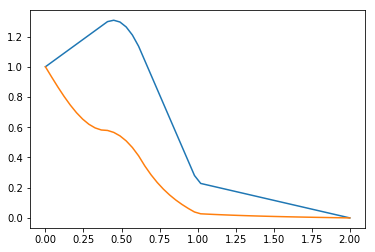

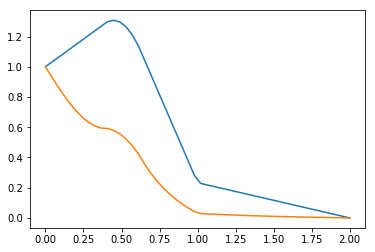

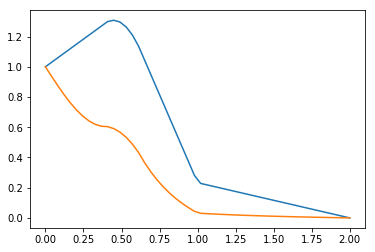

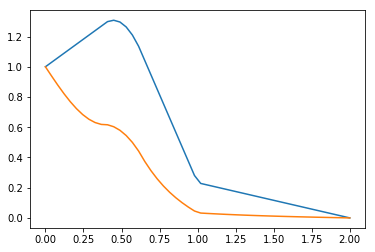

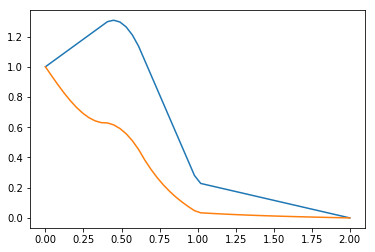

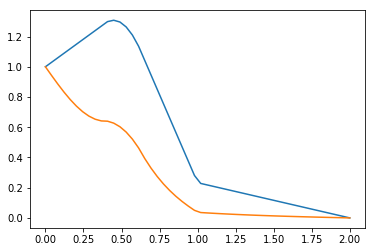

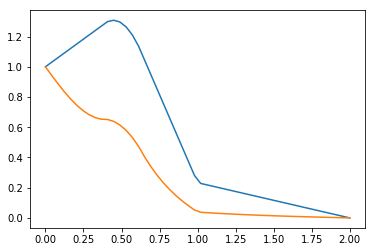

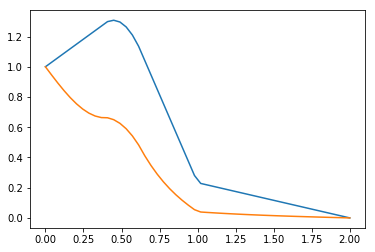

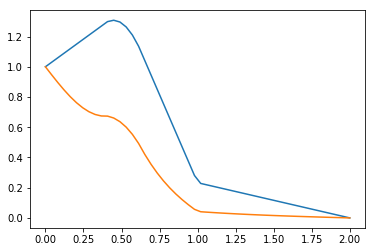

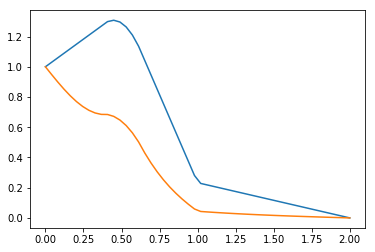

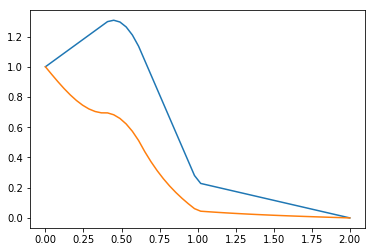

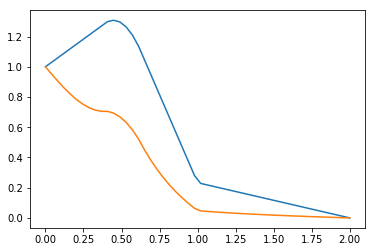

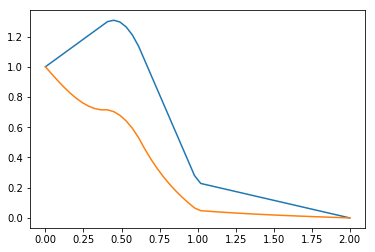

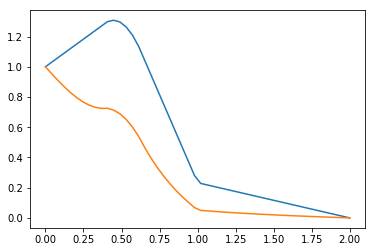

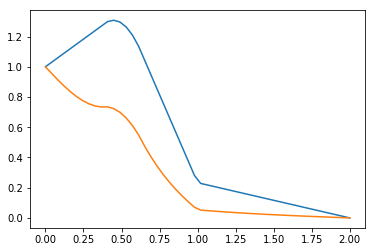

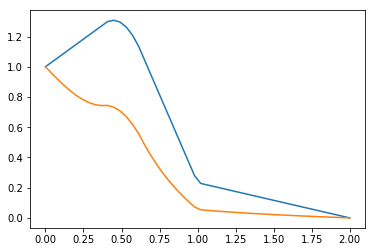

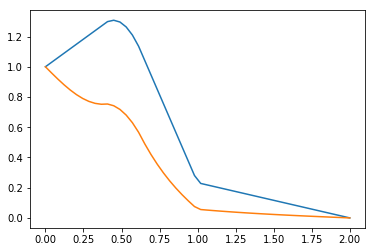

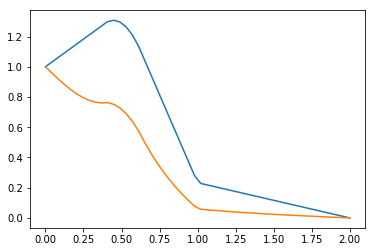

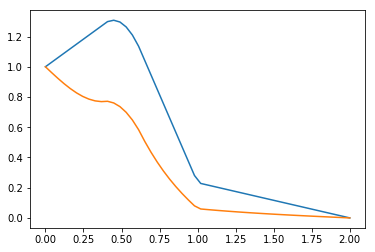

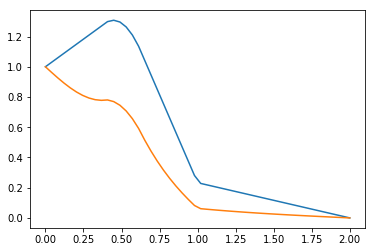

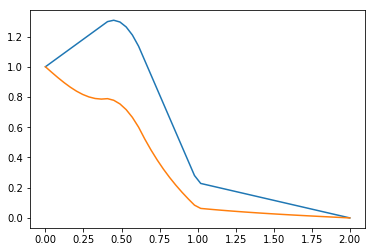

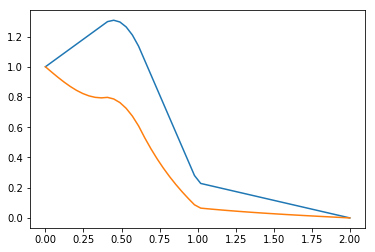

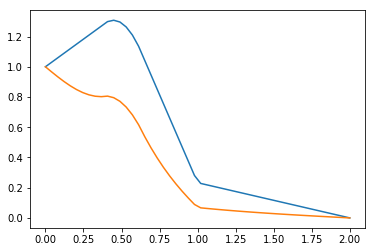

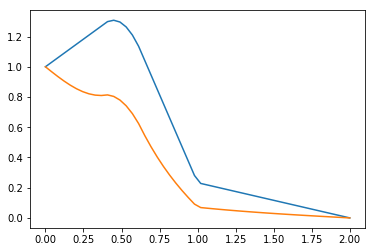

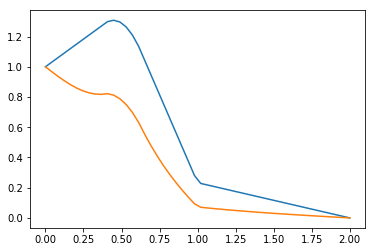

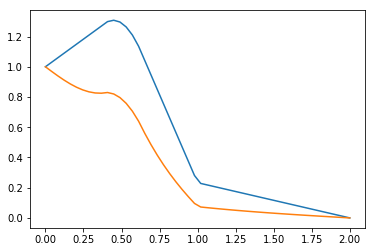

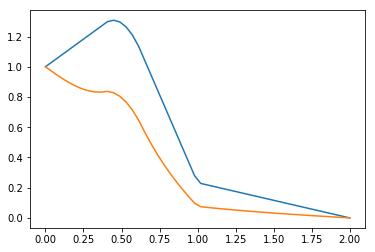

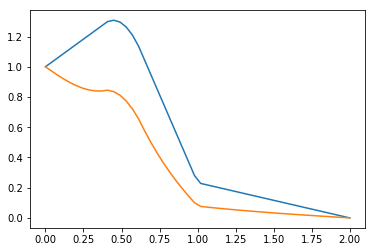

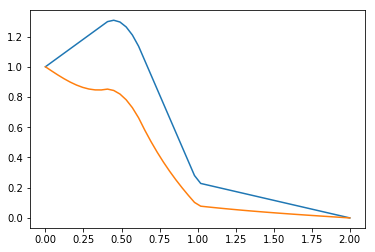

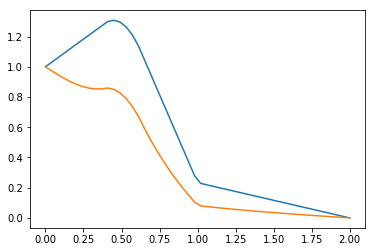

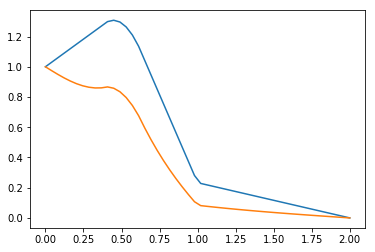

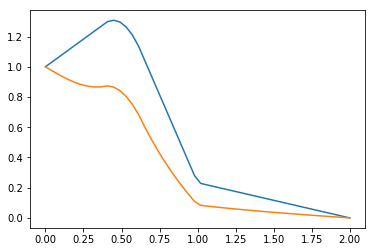

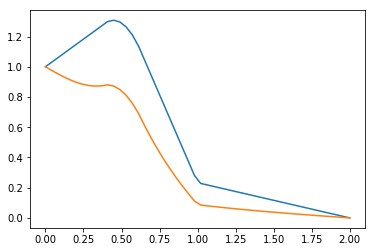

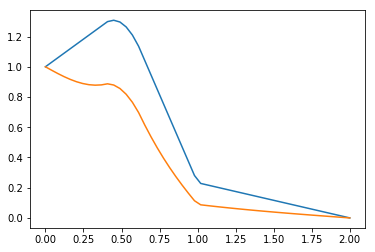

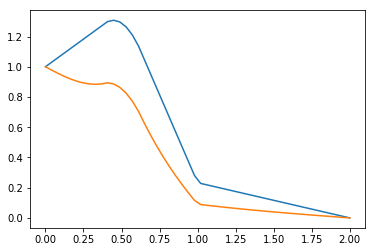

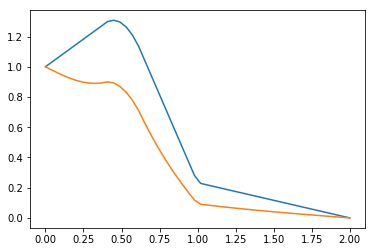

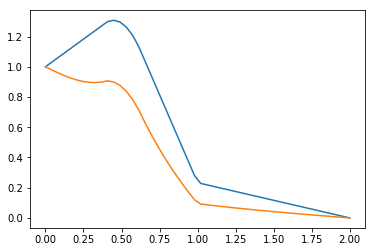

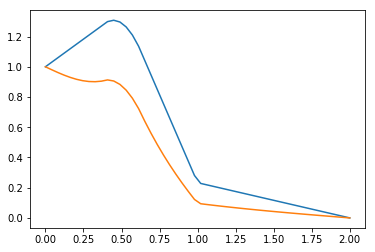

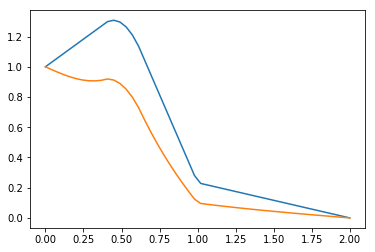

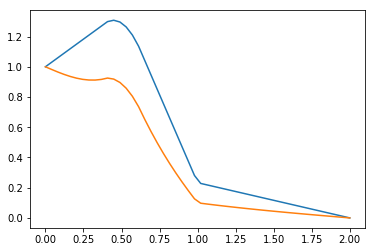

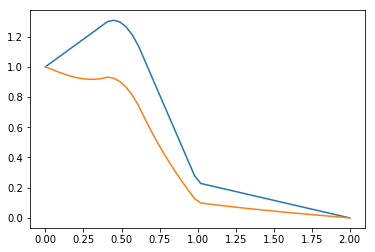

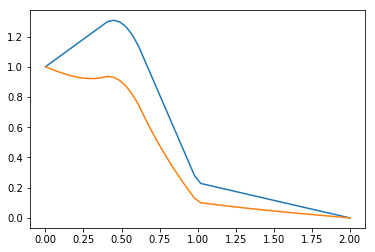

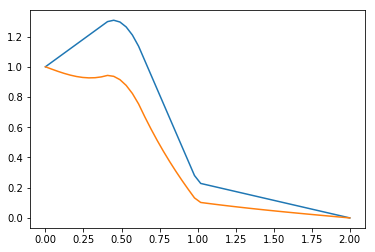

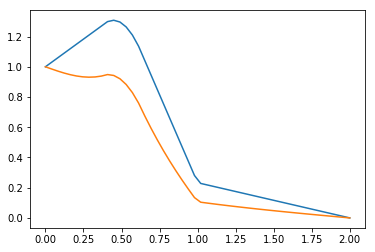

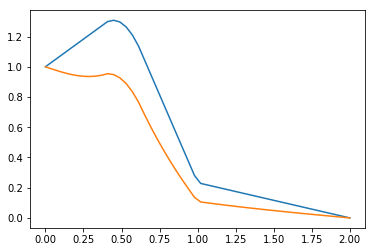

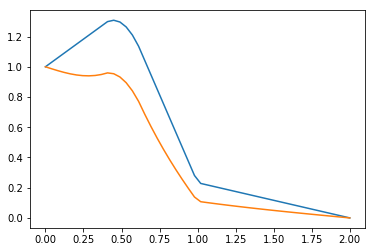

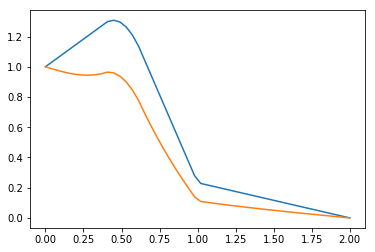

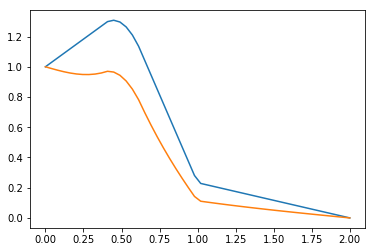

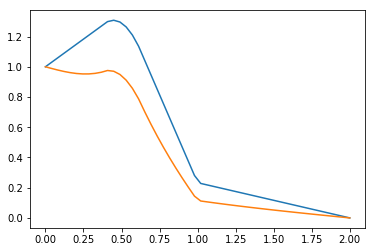

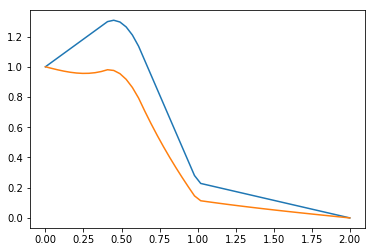

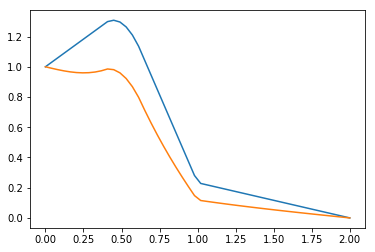

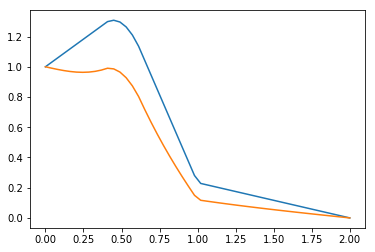

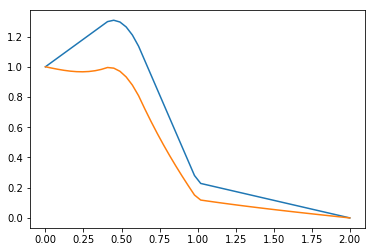

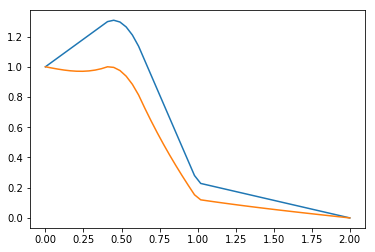

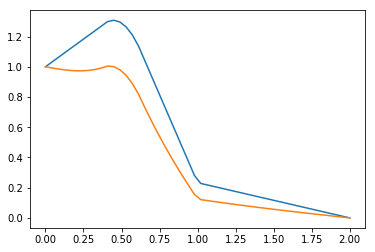

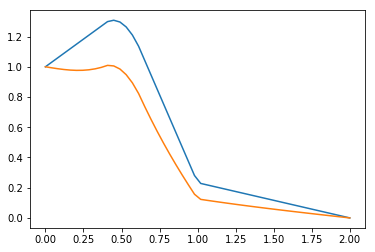

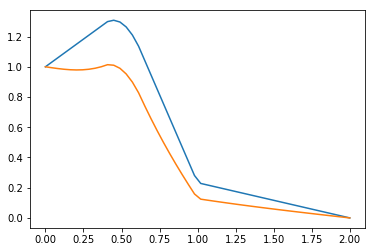

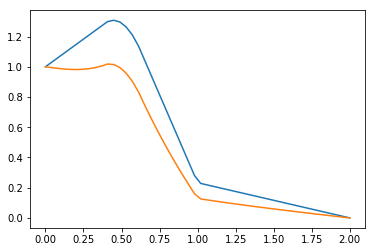

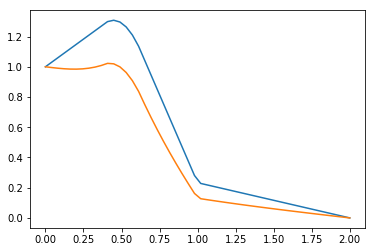

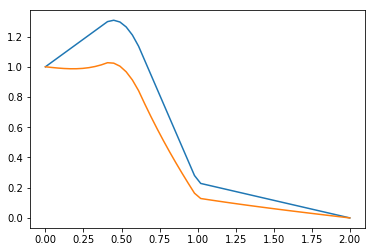

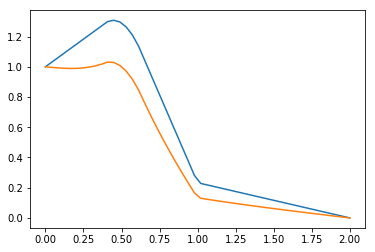

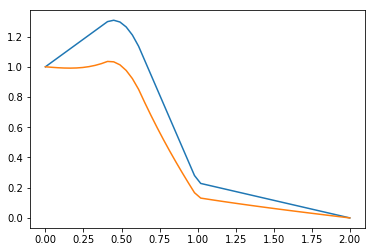

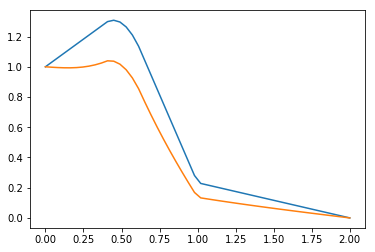

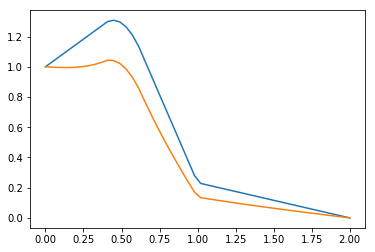

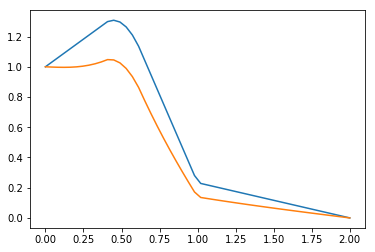

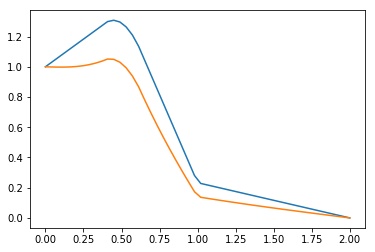

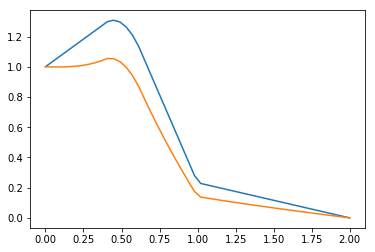

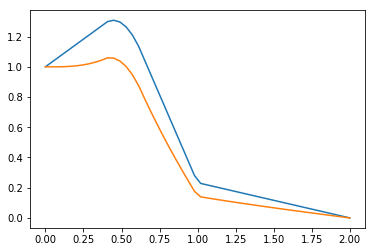

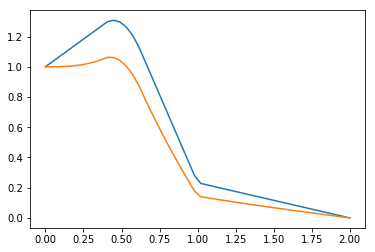

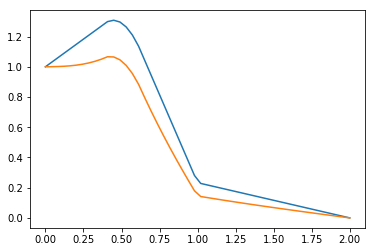

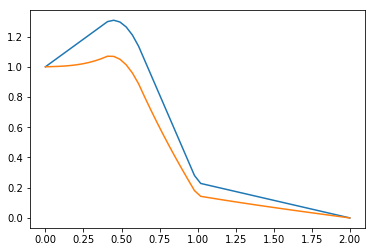

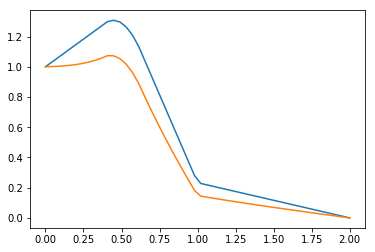

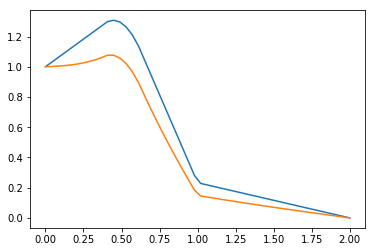

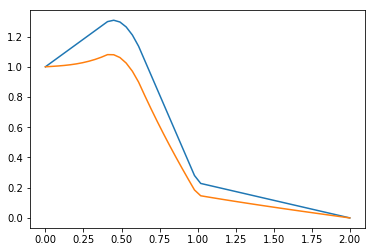

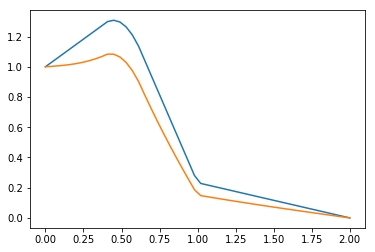

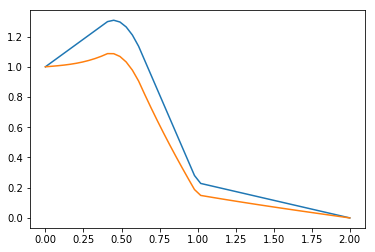

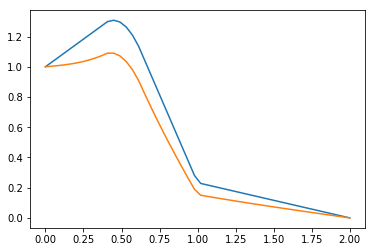

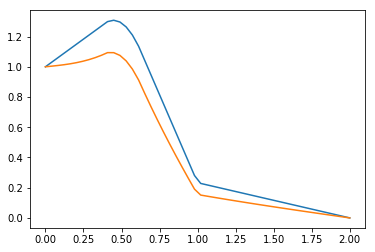

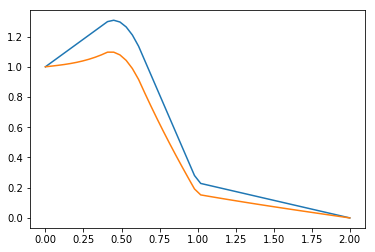

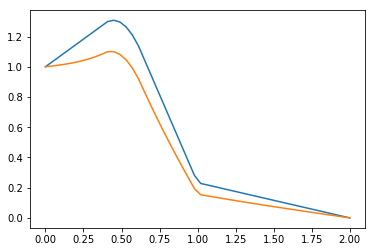

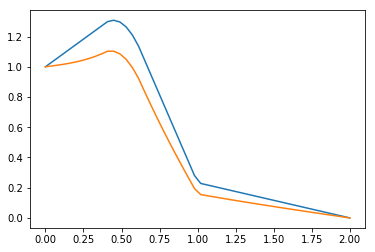

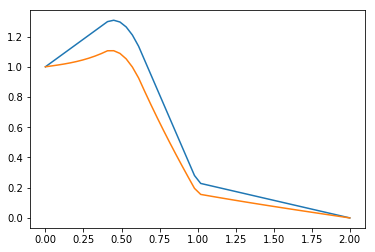

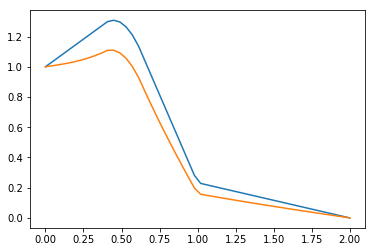

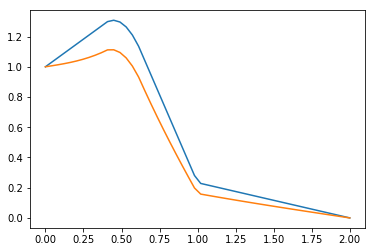

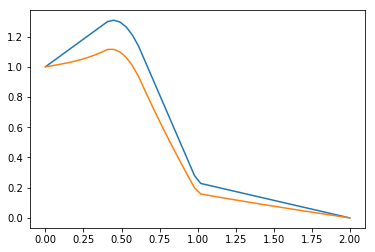

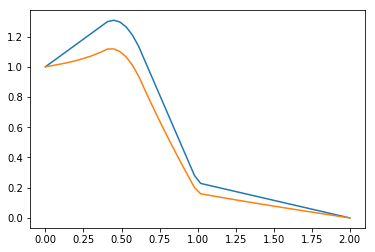

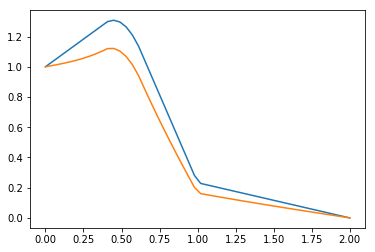

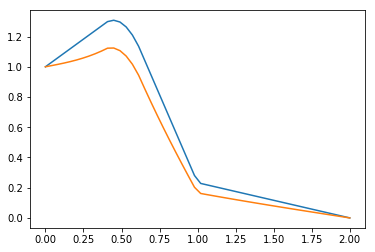

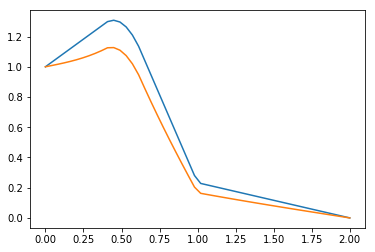

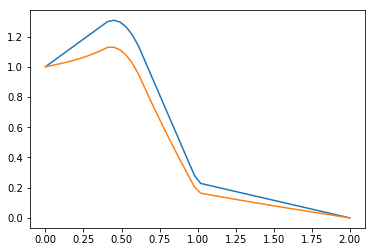

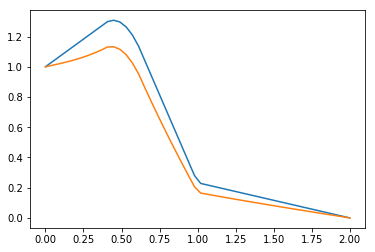

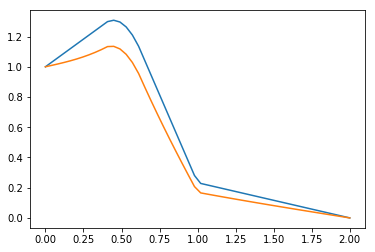

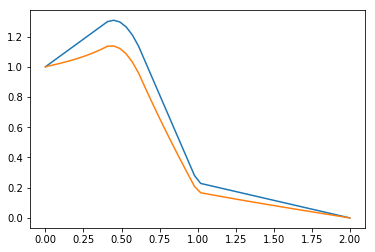

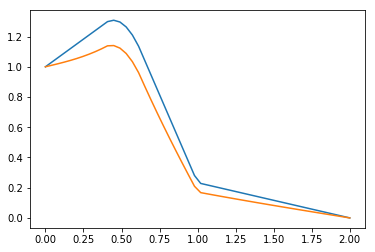

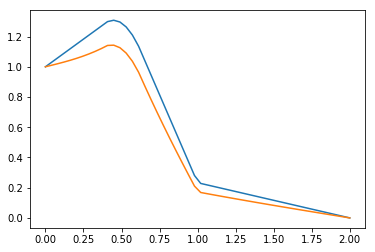

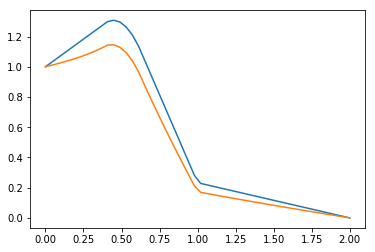

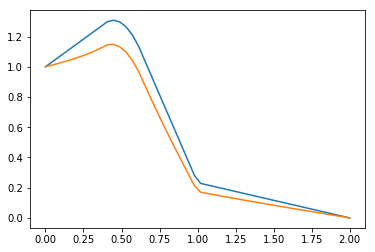

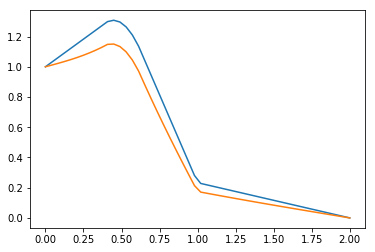

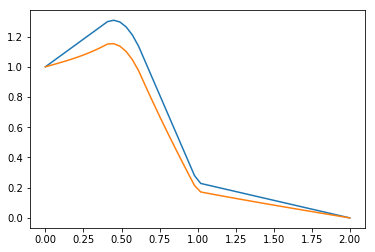

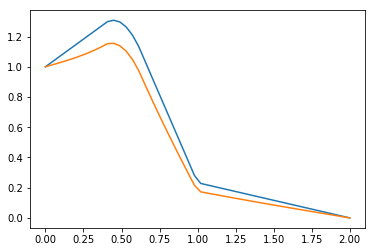

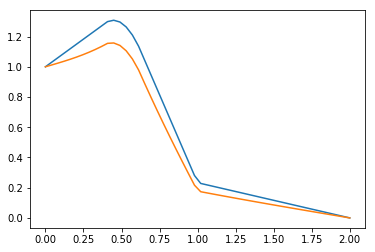

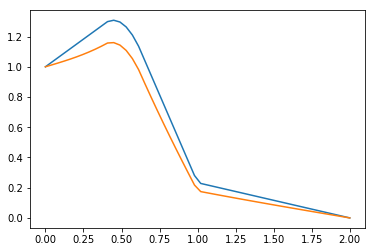

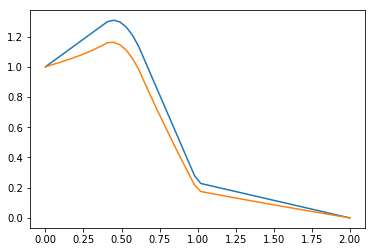

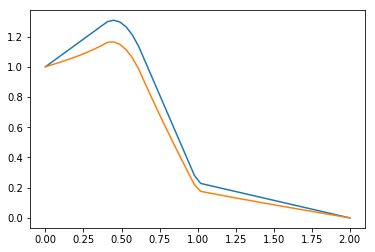

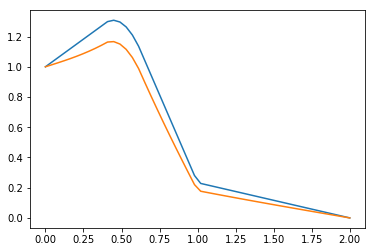

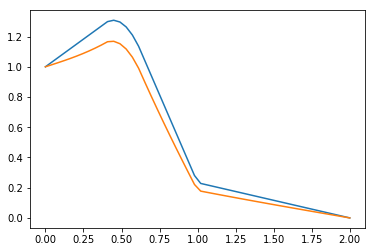

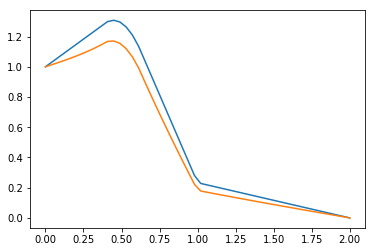

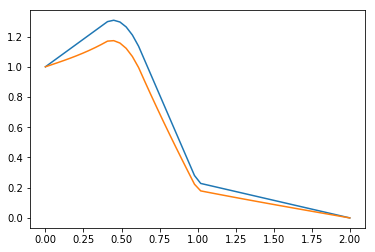

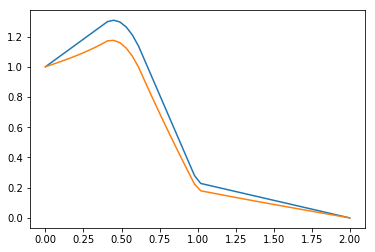

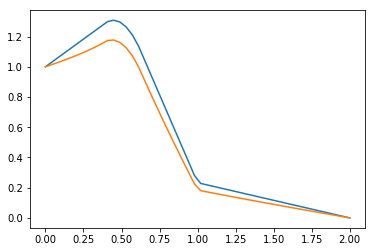

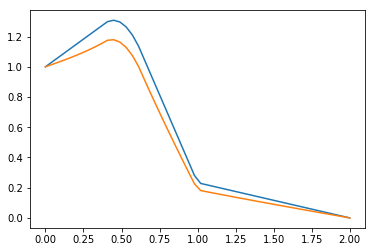

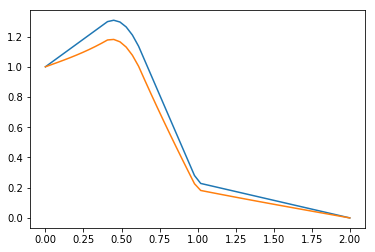

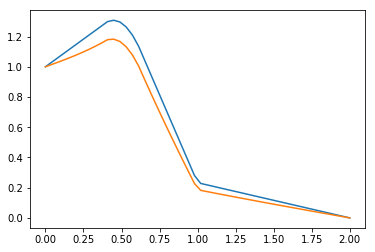

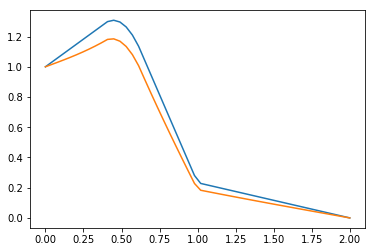

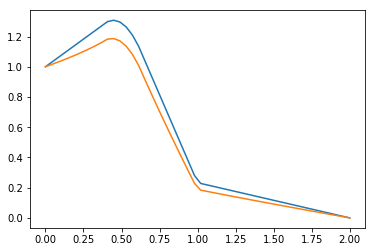

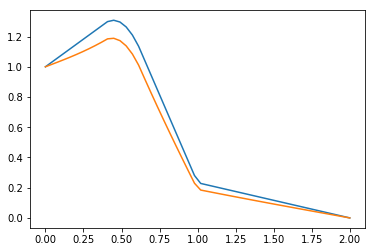

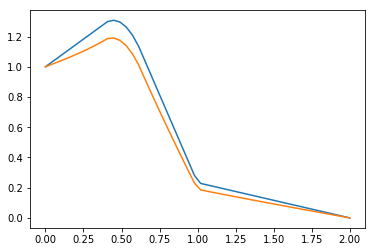

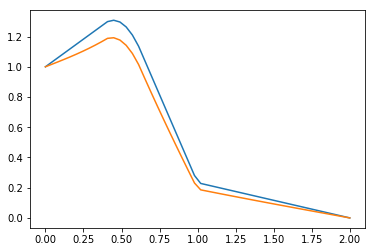

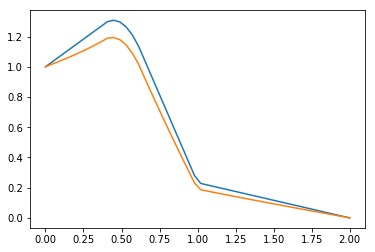

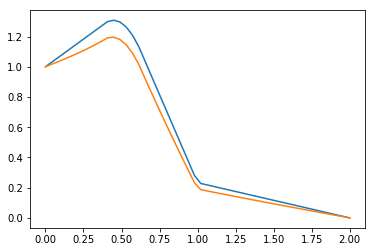

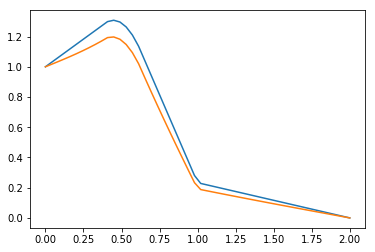

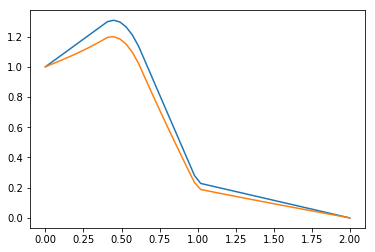

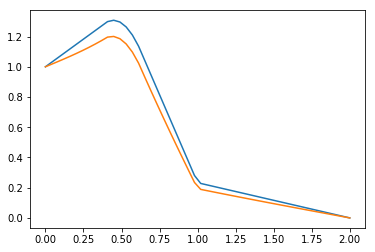

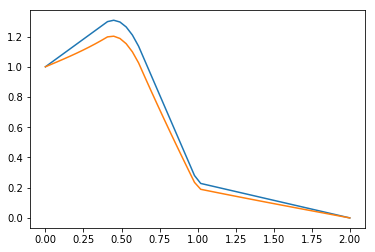

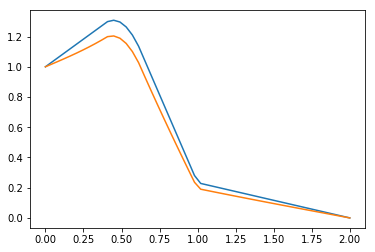

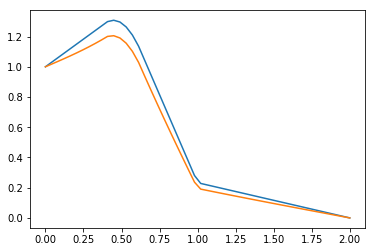

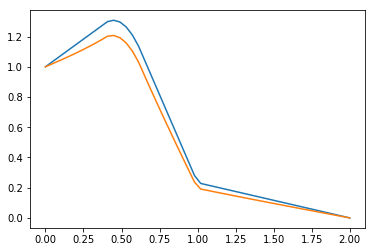

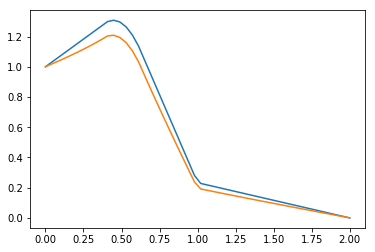

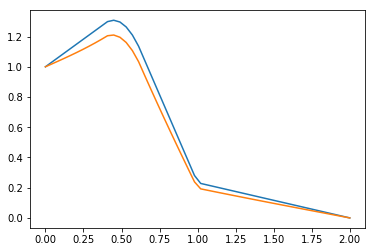

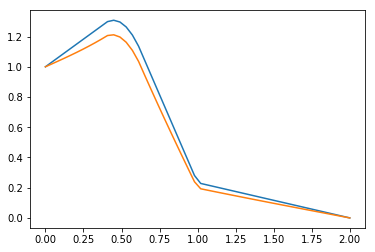

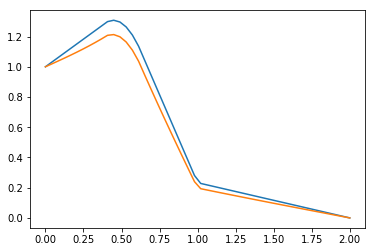

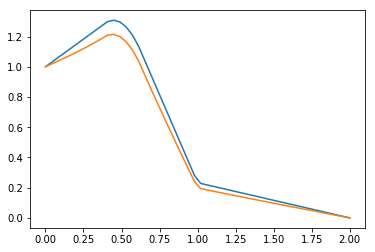

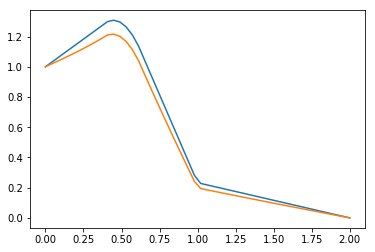

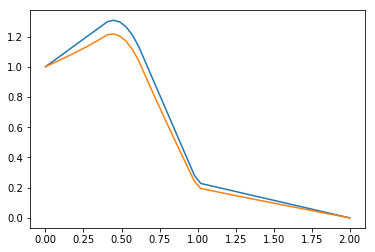

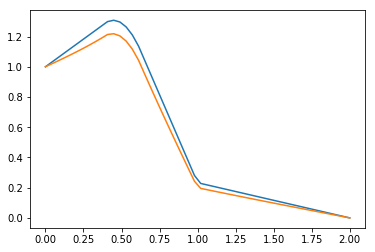

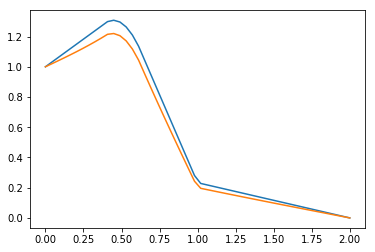

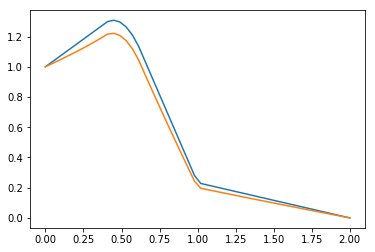

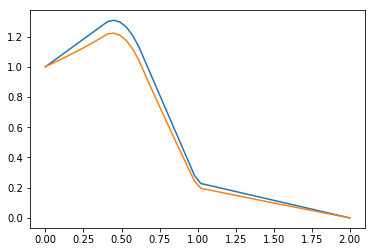

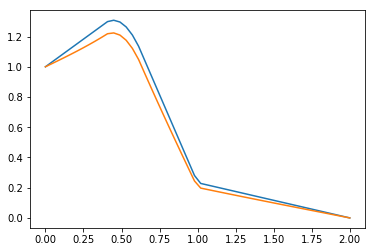

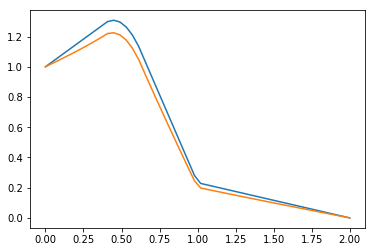

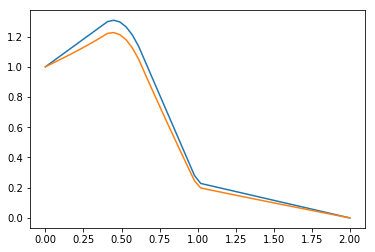

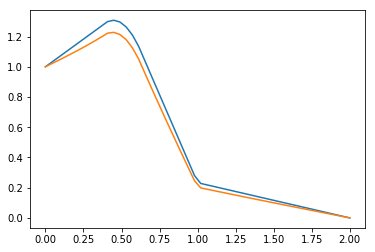

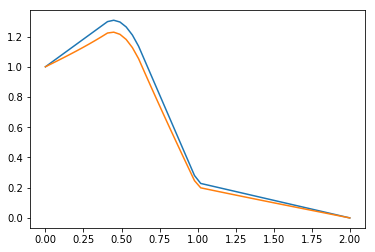

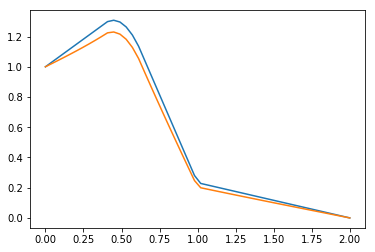

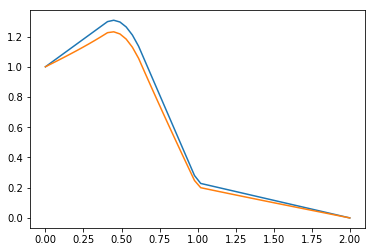

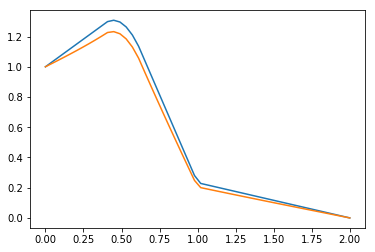

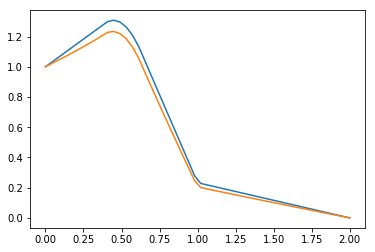

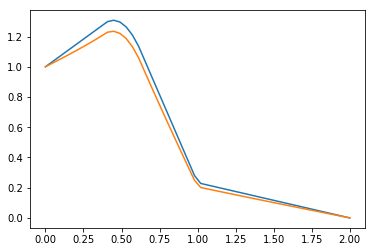

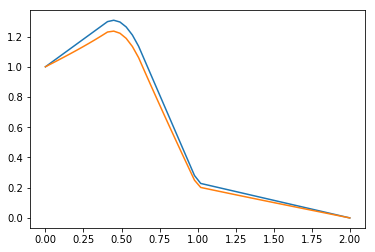

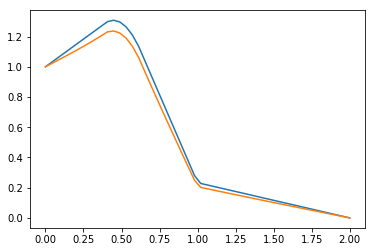

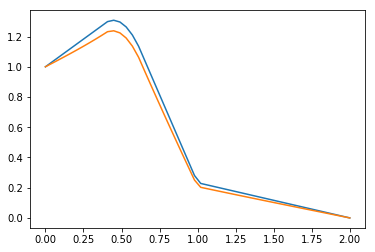

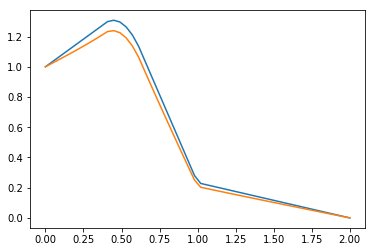

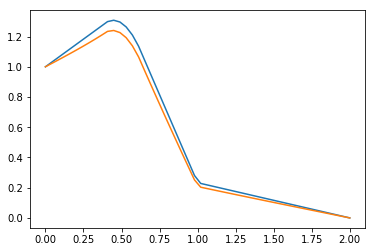

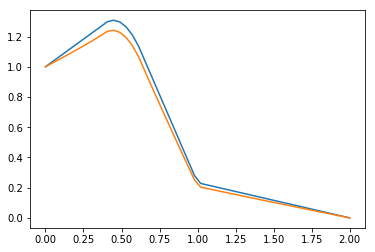

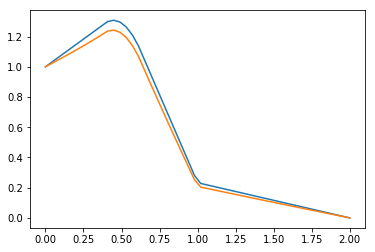

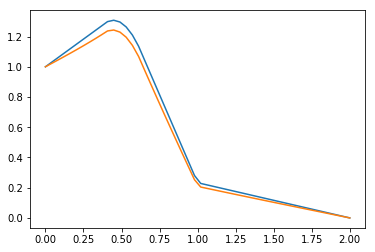

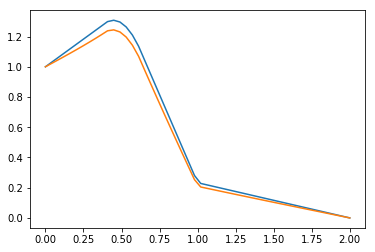

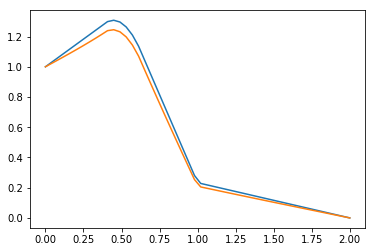

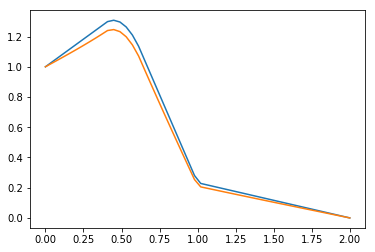

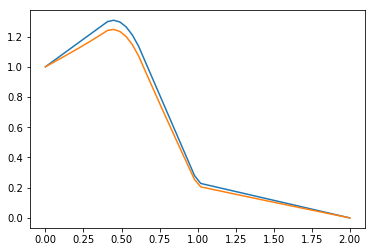

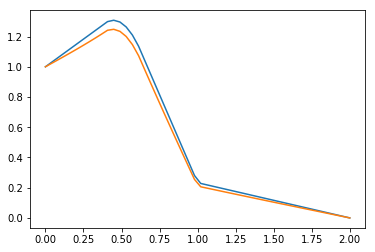

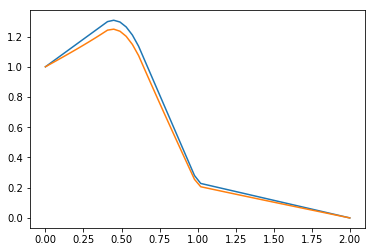

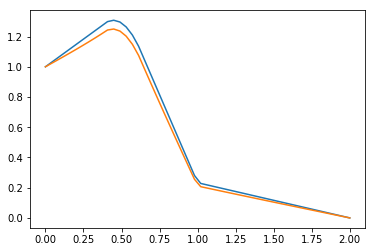

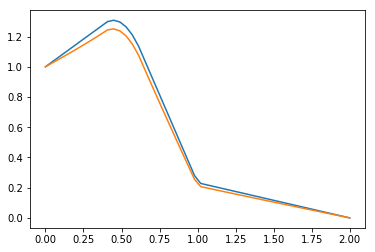

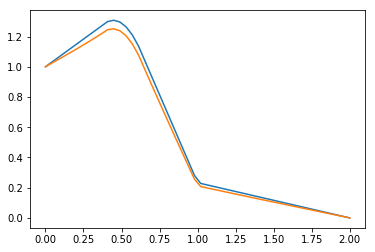

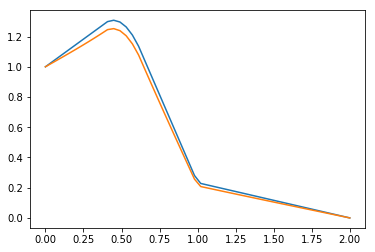

In [6]:
for t in range(nTstp):
    plt.plot(x,c_final, label="Asymptotic concentration")
    plt.plot(x, c[t][:])
    plt.pause(0.01)
    
plt.show()

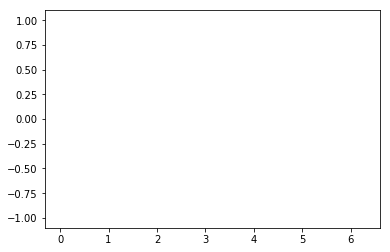

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    return line,


def animate(i):
    line.set_ydata(np.sin(x + i / 100))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True, save_count=50)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# from matplotlib.animation import FFMpegWriter
# writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()